## Calibration and $T_1$ and $T_2$ using Quantum Computers

In this notebook my aim is to firstly measure a optimal value for the frequency of the qubit, doing a frequency sweep, where my aim is to find the value in which the probability of $|1\rangle$ is found. In addition to this measure an optimal amplitude for the $\pi$ pulse using an Rabi Experiment. With this I will calculate the $T_1$ and $T_2$ values for qubit 0 in the real quantum computer: ***ibm_osaka***. In order to calculate $T_2$ I will use a simple Dynamical Decoupling routine called Hahn Echo. This notebook follows the steps done by [1].

[1] Qiskit. Calibrating Qubits with Pulses. https : / / github . com / Qiskit / textbook / blob /
main/notebooks/quantum-hardware-pulses/calibrating-qubits-pulse.ipynb. 



In [1]:
import qiskit

In [2]:
qiskit

<module 'qiskit' from '/Users/pedroalbuquerque/anaconda3/envs/qic/lib/python3.12/site-packages/qiskit/__init__.py'>

In [1]:
from qiskit import QuantumCircuit, transpile, assemble, schedule
from qiskit import pulse, schedule
from qiskit.pulse.library import Gaussian
from qiskit_ibm_runtime import QiskitRuntimeService
import numpy as np
from qiskit.circuit import Gate, Parameter
import matplotlib.pyplot as plt
from qiskit.pulse.library import Drag
from qiskit.visualization import plot_histogram
from qiskit_ibm_runtime import QiskitRuntimeService


In [2]:
from scipy.optimize import curve_fit  ### Usaremos a função do scipy curve_fit para fazer o ajuste do decaimento exponencial
# a documentação do curve_fit explica o uso de cada uma das funções utilizadas no código
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html
import numpy as np

In [3]:
service = QiskitRuntimeService()

backend = service.get_backend('ibm_osaka')

In [4]:
device = backend
print(device)

<IBMBackend('ibm_osaka')>


In [8]:
device_def = device.defaults();device_config = device.configuration()

In [9]:
dt = device_config.dt
print(f"Sampling time: {dt*1e9} ns") 

Sampling time: 0.5 ns


In [12]:
def get_closest_multiple_of_16(num):
    return int(num + 8) - (int(num + 8) % 16)

In [33]:
# unit conversion factors -> all backend properties returned in SI (Hz, sec, etc.)
GHz = 1.0e9 # Gigahertz
MHz = 1.0e6 # Megahertz
us = 1.0e-6 # Microseconds
ns = 1.0e-9 # Nanoseconds

# We will find the qubit frequency for the following qubit.
qubit = 0

# The sweep will be centered around the estimated qubit frequency.
center_frequency_Hz = device_def.qubit_freq_est[qubit]        # The default frequency is given in Hz
                                                                    # warning: this will change in a future release
print(f"Qubit {qubit} has an estimated frequency of {center_frequency_Hz / GHz} GHz.")

# scale factor to remove factors of 10 from the data
scale_factor = 1e-7

# We will sweep 40 MHz around the estimated frequency
frequency_span_Hz = 40 * MHz
# in steps of 1 MHz.
frequency_step_Hz = 1 * MHz

# We will sweep 20 MHz above and 20 MHz below the estimated frequency
frequency_min = center_frequency_Hz - frequency_span_Hz / 2
frequency_max = center_frequency_Hz + frequency_span_Hz / 2
# Construct an np array of the frequencies for our experiment
frequencies_GHz = np.arange(frequency_min / GHz, 
                            frequency_max / GHz, 
                            frequency_step_Hz / GHz)

print(f"The sweep will go from {frequency_min / GHz} GHz to {frequency_max / GHz} GHz \
in steps of {frequency_step_Hz / MHz} MHz.")

Qubit 0 has an estimated frequency of 4.822503223976095 GHz.
The sweep will go from 4.802503223976095 GHz to 4.842503223976095 GHz in steps of 1.0 MHz.


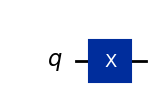

In [13]:
circ_x = QuantumCircuit(1)
circ_x.x(0)
circ_x.draw('mpl')

In [14]:
schedule(circ_x, backend=device)

Schedule((0, Play(Drag(duration=120, sigma=30, beta=-0.19605575294657676, amp=0.1886518916448078, angle=0.0, name='Xp_d0'), DriveChannel(0), name='Xp_d0')), name="circuit-158")

In [1]:
dur = 120
sigma = 30
damp = 0.1886518916448078

In [36]:
freq = Parameter('freq')
with pulse.build(backend=backend, default_alignment='sequential', name='Frequency sweep') as sweep_sched:
    drive_chan = pulse.drive_channel(qubit)
    pulse.set_frequency(freq, drive_chan)
    
    # Drive pulse samples
    pulse.play(pulse.Gaussian(duration=dur,
                              sigma=sigma,
                              amp=damp,
                              name='freq_sweep_excitation_pulse'), drive_chan)

In [37]:
sweep_gate = Gate("sweep", 1, [freq])

qc_sweep = QuantumCircuit(1, 1)

qc_sweep.append(sweep_gate, [0])
qc_sweep.measure(0, 0)
qc_sweep.add_calibration(sweep_gate, (0,), sweep_sched, [freq])

# Create the frequency settings for the sweep (MUST BE IN HZ)
frequencies_Hz = frequencies_GHz*GHz
exp_sweep_circs = [qc_sweep.assign_parameters({freq: f}, inplace=False) for f in frequencies_Hz]

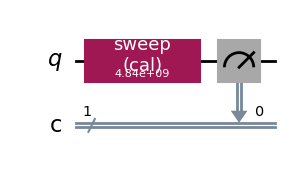

In [41]:
exp_sweep_circs[-1].draw('mpl')

In [42]:
num_shots = 1024

job = backend.run(exp_sweep_circs, 
                  shots=num_shots)

In [43]:
counts = job.result().get_counts()

In [46]:
for entry in counts:
    if '0' in entry and entry['0'] == 4096:
        entry['1'] = 0
    elif '1' in entry and entry['1'] == 4096:
        entry['0'] = 1
prob_1 = [i['1']/sum(i.values()) for i in counts]

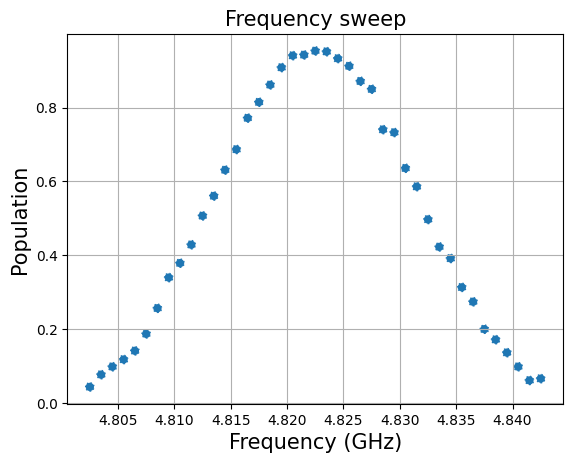

In [60]:
plt.scatter(frequencies_GHz, prob_1, marker = 'o', linestyle = ':', label = r'$|1\rangle$') 
plt.title("Frequency sweep", fontsize=15)
plt.xlabel('Frequency (GHz)', fontsize=15)
plt.ylabel('Population', fontsize=15)
plt.grid()
plt.show()

In [187]:
fit_params, y_fit = fit_function(frequencies_GHz,
                                 prob_1, 
                                 lambda x, A, q_freq, B, C: (A / np.pi) * (B / ((x - q_freq)**2 + B**2)) + C,
                                 [2*np.pi, 4.835, 0.5, 1]# initial parameters for curve_fit
                                )

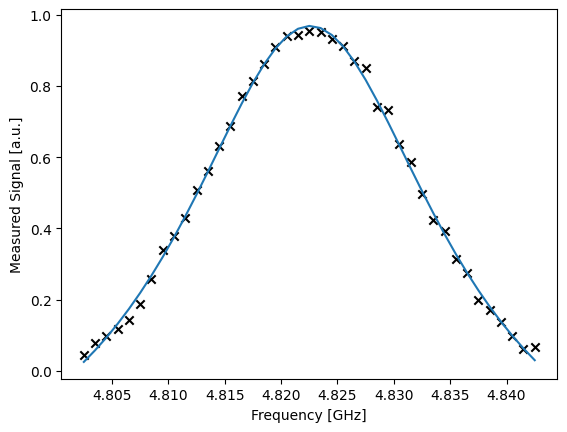

In [188]:
plt.scatter(frequencies_GHz, prob_1, marker='x', color='black')
plt.plot(frequencies_GHz, y_fit)

plt.grid()

plt.xlabel("Frequency [GHz]")
plt.ylabel("Population")
plt.show()

In [190]:
A, rough_qubit_frequency, B, C = fit_params
rough_qubit_frequency = rough_qubit_frequency*GHz # make sure qubit freq is in Hz
print(f"We've updated our qubit frequency estimate from "
      f"{round(device_def.qubit_freq_est[qubit] / GHz, 5)} GHz to {round(rough_qubit_frequency/GHz, 5)} GHz.")


We've updated our qubit frequency estimate from 4.8225 GHz to 4.82258 GHz.


### Rabi Experiment

Isidor Rabi (1898-1988) is a nobel-prize winner (1944) physicist who helped discover and develop Nuclear Magnetic Resonance (NMR). During the 1930's Rabi was one of the first scientists to investigate nuclear magnetic properties using molecular beams. A very important starting point was one of the first detections of NMR in a beam of lithium. Using molecular beams with an oscillating magnetic field, produced by an alternating current, between two static fields and a constant frequency he was able to determine the right strength in which the lithium nuclei in the beam "flipped" its spin, which means it cheanged from one of the two discret energy levels avaiable in the spin of a nuclei. Analogously the experiment that will be performed in the following code aims to determine the amplitude where the qubit goes from its ground state, $|0\rangle$, to its excited state, $|1\rangle$, by varying the amplitudes. Whereas Rabi used the spin of nuclei and varying magnetic fields, here superconducting qubits and micorwave-pulses are used. The pulses are created using Qiskit Pulse, which is better explained in the notebook "Complete_Pulse.ipynb" (https://github.com/pedr19faria/CBPF-Pulse/blob/main/Complete-Pulse%20(1).ipynb) and are a useful way to gain more control over the circuits, possibilitanting more trustworthy circuits. Determining a $\pi$ pulse, which is equivalent to a $X$ gate is extremely important, because a calibrated $\pi$ pulse possibilitates an array of other experiments, such as $T_1$ Experiment and $T_2$ with Hahn echoes, which will be done later in this notebook.

Reference: Giunta, C. J., & Mainz, V. V. (2020). Discovery of Nuclear Magnetic Resonance: Rabi, Purcell, and Bloch. In Pioneers of Magnetic Resonance (Chapter 1, pp. 3-20). ACS Symposium Series, Vol. 1349. American Chemical Society. DOI: 10.1021/bk-2020-1349.ch001

In [9]:
num_rabi_points = 50 # do a span of 50

inital_amp = 0.01
end_amp = 0.75

rabi_points = np.linspace(inital_amp, end_amp, num_rabi_points)

In [192]:
drive_amp = Parameter('drive_amp')
with pulse.build(backend = device, default_alignment = 'sequential', name = 'Rabi Experiment') as rabi_sched:
    drive_chan = pulse.drive_channel(qubit)
    pulse.set_frequency(rough_qubit_frequency, drive_chan)

    pulse.play(pulse.Gaussian(duration = dur, amp=drive_amp, sigma = sigma, name = 'Rabi Pulse'), drive_chan)
    
rabi_schedules = [rabi_sched.assign_parameters({drive_amp: a}, inplace = False) for a in rabi_points]
    

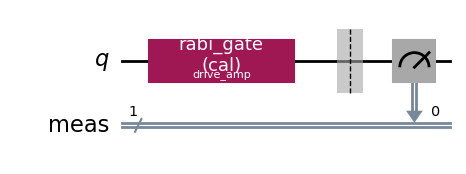

In [193]:
qc = QuantumCircuit(1)
rabi_gate = Gate('rabi_gate', 1, [drive_amp])
qc.append(rabi_gate,[0])# putting the custom gate in the qubit 0 in the Quantum Circuit
qc.measure_all()

qc.add_calibration(rabi_gate, [0], rabi_sched)
qc.draw('mpl')

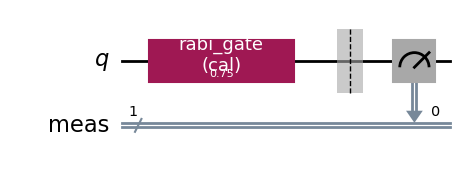

In [194]:
rabi_circuits = [qc.assign_parameters({drive_amp: a}, inplace = False) for a in rabi_points]
rabi_circuits[-1].draw('mpl')

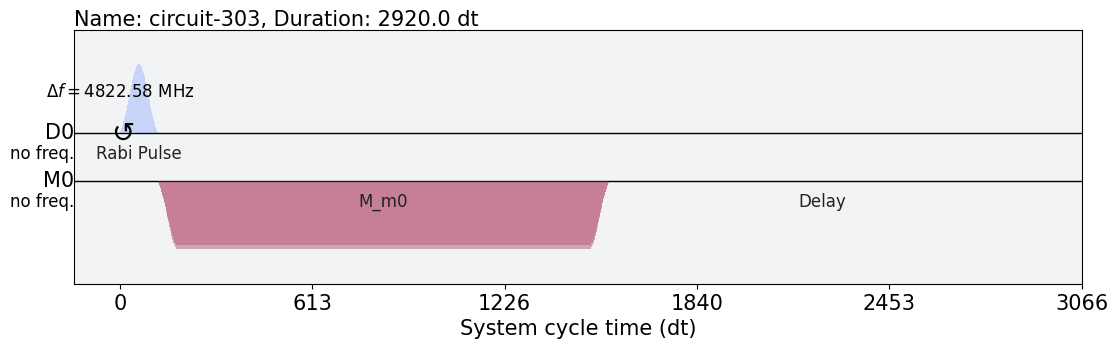

In [195]:
scheduled_circuits = schedule(rabi_circuits, backend=device)
scheduled_circuits[-1].draw()

In [196]:
shots = 2**10 # 1024
job = device.run(rabi_circuits, shots = shots)
print(job.job_id())


creat1r3vh8g008chyf0


In [7]:

job = service.job('creat1r3vh8g008chyf0')

In [8]:
results = job.result().get_counts()
for entry in results:
    if '0' in entry and entry['0'] == 4096:
        entry['1'] = 0
    elif '1' in entry and entry['1'] == 4096:
        entry['0'] = 1
prob_1 = [i['1']/sum(i.values()) for i in results]

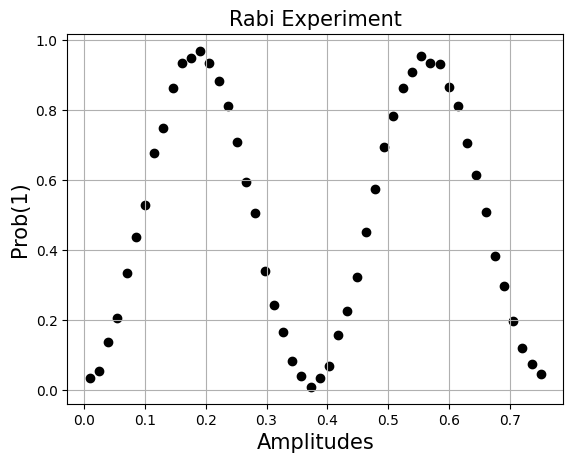

In [10]:
plt.scatter(rabi_points, prob_1, color = 'black') 
plt.title("Rabi Experiment", fontsize=15)
plt.xlabel('Amplitudes', fontsize=15)
plt.ylabel('Prob(1)', fontsize=15)
plt.grid()
plt.show()

The equation which describes the curve shown in the Rabi Oscillations is the following:
$$
\begin{equation}
 Acos(\dfrac{2\pi x}{T} - \phi) + B
\end{equation}
$$

Since the $x-axis$ represents the amplitudes and the $y-axis$ the probability of finding the qubit in $1$, it is clear that the period is the array of amplitudes which takes the qubit from $|0\rangle$ and back to it again. Then it can be said that half of a period will represent the amplitude needed to make the qubit go from $|0\rangle$ to $|1\rangle$. Then $amp = \dfrac{T}{2}$.

In [11]:
from scipy.optimize import curve_fit

def fit_function(x_values, y_values, function, initial_parameters):
    fitparams, conv = curve_fit(function, x_values, y_values, initial_parameters)
    y_fit = function(x_values, *fitparams)
    return fitparams, y_fit

In [12]:
fit_param, y_fit = fit_function(rabi_points, prob_1,
                               lambda x, A, B, drive_period, phi: (A*np.cos(2*np.pi*x/drive_period - phi) + B), [0.5,0.5 ,0.35,np.pi])

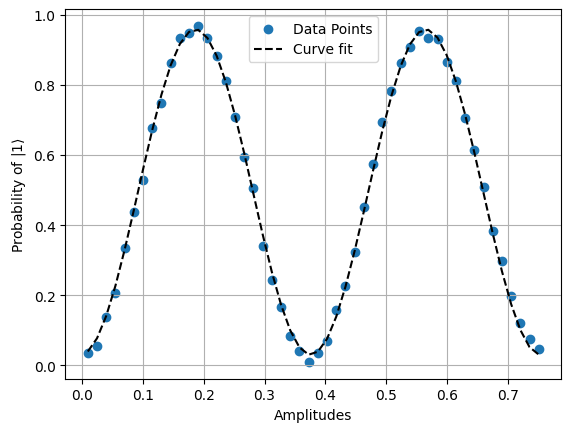

In [14]:
plt.scatter(rabi_points, prob_1, label = 'Data Points') 
plt.plot(rabi_points, y_fit, '--', color= 'black', label = r'Curve fit')
plt.xlabel('Amplitudes')
plt.ylabel(r'Probability of $|1\rangle$')
drive_period = fit_param[2]
plt.grid()
plt.legend()
plt.show()

In [202]:
pi_amp = abs(drive_period/2)
print(f'Pi Amplitude = {pi_amp}')

Pi Amplitude = 0.18896653879211497


Now the $\pi$ pulse can be defined as:

In [203]:
with pulse.build(backend = device) as pi_pulse:
    drive_chan = pulse.drive_channel(qubit)
    pulse.set_frequency(rough_qubit_frequency, drive_chan)
    pulse.play(pulse.Gaussian(duration = dur, amp=pi_amp, sigma = sigma, name = 'Pi Pulse'), drive_chan)

In [204]:
print(pi_pulse)

ScheduleBlock(SetFrequency(4822579340.932141, DriveChannel(0)), Play(Gaussian(duration=120, sigma=30, amp=0.18896653879211497, angle=0.0, name='Pi Pulse'), DriveChannel(0), name='Pi Pulse'), name="block6", transform=AlignLeft())


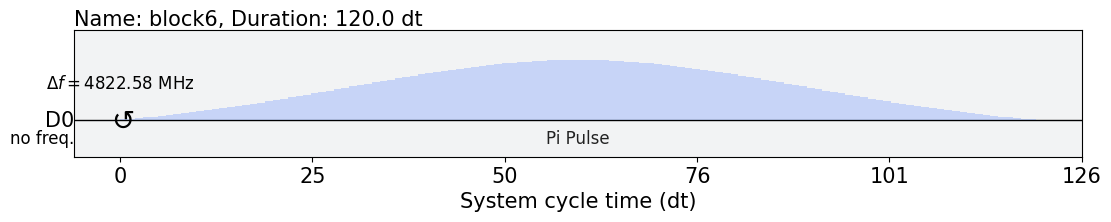

In [205]:
pi_pulse.draw()

### $T_1$ with Pulse

In NMR after a single pulse the collection of nuclear spins will present a certain result magnetization in a plane, according to the pulse given, and they will precess around $B_0$, the magnetic field. However, since there exists external factors the system will decay with time, in an exponential manner, returning to the initial direction of the collection of nuclear spins. This is called longitudinal relatxation.

This happens, however, in any Quantum Computer that is not perfectly isolated from its environment, since interactions between external magnetic fields, temperature and many other factors will influence the Qubit - which in the NMR case is the spin- to relax and return to its ground state. We can visualize and understand this process using the Quantum Computers avaible by IBM, by measuring the T1 relaxation time of simulators and real Quantum Computers. In the following code we will measure T1 of a IBM fake backend simulator, Fake Armonk. 

**How can we measure T1?**

Since T1 is the time constant that describes the process of the qubit decaying from its excited state to its original ground state we can measure it by first preparing the qubit in the excited state, $|1>$, by applying the *NOT* gate, represented by *X*, and waiting some time until measuring the system. This will be repeated  for different wait times and we will notice how the longer we wait, the smaller the probability of finding the qubit in the $|1>$ state will be. 

This probability can be described by an exponential decay given by the formula:

$
\begin{align}
A + Be^{t/T_1}  \text{         }(1)
\end{align}
$

$A$, $B$ and $T_1$ are all constants that will be determined throught the experiment.

In [19]:
# Delimit time span:
us = 1e-9
time_max = 900*us
delay_time_secs = np.linspace(1*us, time_max, 200)

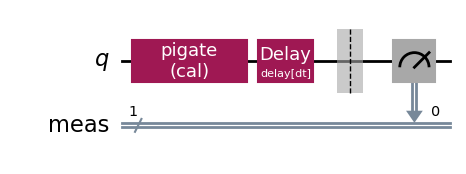

In [224]:
delay = Parameter('delay')
circ_t1 = QuantumCircuit(1)
pigate = Gate('pigate', 1, [])
circ_t1.append(pigate, [0])
circ_t1.add_calibration('pigate',[0],pi_pulse)
circ_t1.delay(delay,0)
circ_t1.add_calibration("x",[0], pi_pulse)
circ_t1.measure_all()
circ_t1.draw('mpl')

In [225]:
circuits_t1 = [circ_t1.assign_parameters({delay: get_closest_multiple_of_16((int(a/(dt))))}, inplace = False) for a in delay_time_secs]

ERROR Failed to execute program: Delays must be a multiple of 8 samples

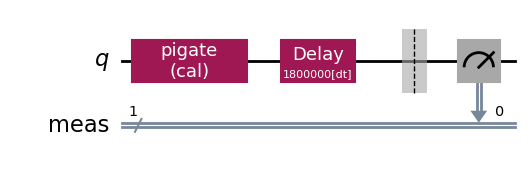

In [226]:
circuits_t1[-1].draw('mpl')

In [227]:
pigate

Instruction(name='pigate', num_qubits=1, num_clbits=0, params=[])

In [228]:
schedule_t1 = schedule(circuits_t1, backend=device )


In [229]:
print(schedule_t1[-1])

Schedule((0, SetFrequency(4822579340.932141, DriveChannel(0))), (0, Play(Gaussian(duration=120, sigma=30, amp=0.18896653879211497, angle=0.0, name='Pi Pulse'), DriveChannel(0), name='Pi Pulse')), (120, Delay(1800000, DriveChannel(0))), (1800120, Acquire(1440, AcquireChannel(0), MemorySlot(0))), (1800120, Play(GaussianSquare(duration=1440, sigma=32, width=1312, amp=0.14867, angle=-2.3262423350107704, name='M_m0'), MeasureChannel(0), name='M_m0')), (1801560, Delay(1360, MeasureChannel(0))), name="circuit-705")


In [230]:
num_shots = 2**10

job_t1 = device.run(circuits_t1, shots = num_shots)
print(job_t1.job_id())

crej7gyqjh0g008fqbw0


In [15]:
job_t1 = service.job('crej7gyqjh0g008fqbw0')

In [16]:
t1_res = job_t1.result().get_counts()

In [17]:
prob_T1 = [i['1']/sum(i.values()) for i in t1_res]

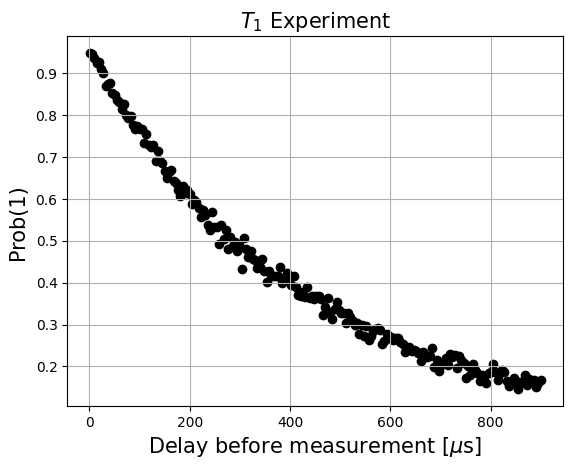

In [20]:
t1_values = []

plt.scatter(delay_time_secs/us, prob_T1, c = 'black') 
plt.title(r"$T_1$ Experiment", fontsize=15)
plt.xlabel(r'Delay before measurement [$\mu$s]', fontsize=15)
plt.ylabel('Prob(1) ', fontsize=15)
plt.grid()
plt.show()

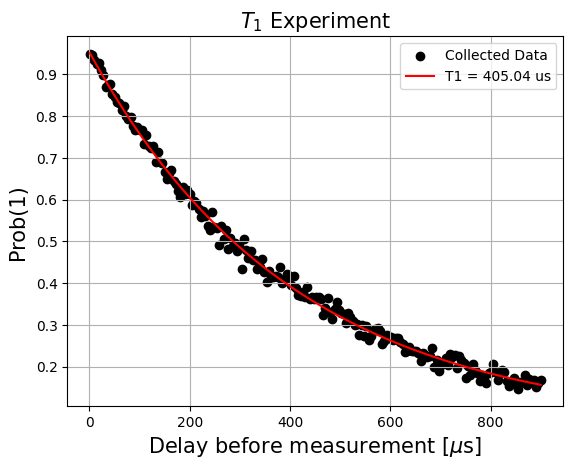

In [234]:
fit_params, y_fit = fit_function(delay_time_secs/us, prob_1, lambda x, A, C, T1: (A*np.exp(-x/T1) + C), [1,0,100])

T1 = fit_params[-1]

plt.scatter(delay_time_secs/us, prob_T1, c = 'black', label = 'Collected Data') 
plt.plot(delay_time_secs/us, y_fit, c= 'red', label = f'T1 = {T1:.2f} us')
plt.title(r"$T_1$ Experiment", fontsize=15)
plt.xlabel(r'Delay before measurement [$\mu$s]', fontsize=15)
plt.ylabel('Prob(1) ', fontsize=15)
plt.grid()
plt.legend()
plt.show()

In [235]:
error = ((T1 - 417.42)/417.42)*100
print(f'Error = {np.abs(error):.2f}%')

Error = 2.97%


Median T1 for qubit 0, as indicated on the IBM website is of $178.91 \text{us}$. Whereas in this experiment we found $174.24 \text{us}$. 
An error of $\epsilon = 2.65\%$. 

### $T_2$ Experiment using Hahn Echoes:

The $T_2$ time/Transverse relaxation time/Dephasing time characterizes the time where the qubit sufferes a loss of phase. Once again, let's imagine working with a spin qubit. The $T_2$ experiment is started by applying a $\frac{\pi}{2}$ pulse or a Hadamard gate (equivalents), putting the qubit in a state of superposition, ideally represented by ($\frac{1}{\sqrt{2}}(|0\rangle + |1\rangle)$). We may also represent this in the bloch sphere:

Becase of noise the qubit in question will go through a process of dephasing, where the qubit accumulates a random phase - when thinking with spins the vectors will spread through the ***x-axis*** and the net magnetization will start to get smaller making the spin vector represented in the bloch sphere dissappear with time. The time of this dephasing is measured and characterized as $T_2$. This experiment is done by first applying the $\frac{\pi}{2}$ pulse, applying a delay gate - which get longer throughout the experiment- which will let the qubit dephase and applying a $-\frac{\pi}{2}$ pulse once again, taking the qubit back to the ***z-axis*** where it can be measured. If the qubit has not dephased it will be in $0\rangle$, if it has dephased it will be inbetween $0\rangle$ and $\frac{1}{\sqrt{2}}(|0\rangle + |1\rangle)$. 

In order to find a more intrinsic $T_2$ value we may use a sequence of Hahn Echoes, the first Dynamic Decoupling strategy we will study. In NMR it is used to reduce inhomogeneous effects from the magnetic field. It is done by adding a $\pi$ pulse inbetween the $\frac{\pi}{2}$ pulses, with equal delay times before and after the new pulse. The purpose of this addition is because after the first $\frac{\pi}{2}$ pulse the qubit will start to accumulate a random phase in the ***x-axis***, so once we bring the qubit $180$ degrees to the other side it will start to dephase, canceling out the random phase it had gotten. Once the delay time passed we will apply another $\frac{\pi}{2}$ pulse, bringing the qubit back to the ***z-axis*** where it can be measured. The decay happens in the form: 

$$ 
\begin{equation}
A + Be^{t/T_2} 
\end{equation}
$$

Where we will discover $T_2$ the same way done for $T_1$, by curve fitting the decay curve found.

In [242]:
pi2_amp = pi_amp/2

with pulse.build(device) as x90pulse:
    drive_chan = pulse.drive_channel(qubit)
    pulse.set_frequency(rough_qubit_frequency, drive_chan)
    pulse.play(pulse.Gaussian(duration = 120, amp=pi2_amp, sigma = 30, name = 'pi/2 Pulse'), drive_chan)
    

In [21]:
delay_times = np.linspace(1*us, 700*us,100)

In [246]:
delay = Parameter('delay')
with pulse.build(device, default_alignment='sequential', name="T2 delay Experiment") as t2_Schedule:
    drive_chan = pulse.drive_channel(qubit)
    pulse.set_frequency(rough_qubit_frequency, drive_chan)
    pulse.call(x90pulse)
    pulse.delay(delay, drive_chan)
    pulse.call(pi_pulse)
    pulse.delay(delay, drive_chan)
    pulse.call(x90pulse)

In [250]:
circ_T2 = QuantumCircuit(1)

T2Gate = Gate('t2gate', 1, [delay])

circ_T2.append(T2Gate, [0])

circ_T2.measure_all()
circ_T2.add_calibration(T2Gate, (0,), t2_Schedule, [delay])
exp_T2_circuits = [circ_T2.assign_parameters({delay: get_closest_multiple_of_16((int(a/(dt))))}, inplace = False) for a in delay_times]

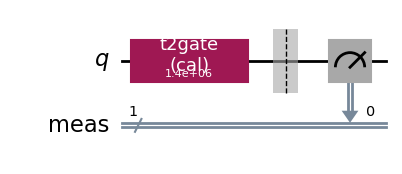

In [251]:
exp_T2_circuits[-1].draw('mpl')

In [239]:
qc_t2 = QuantumCircuit(1)

x90gate = Gate('x90gat', 1, [])
pigate = Gate('pigate', 1, [])

qc_t2.h(0)
qc_t2.delay(delay, 0)
qc_t2.x(0)
qc_t2.delay(delay,0)
qc_t2.h(0)

qc_t2.add_calibration('h', [0], x90pulse)
qc_t2.add_calibration('x', [0], pi_pulse)

qc_t2.measure_all()

exp_t2_circuits = [qc_t2.assign_parameters({delay: get_closest_multiple_of_16((int(a/(dt))))}, inplace = False) for a in delay_times]

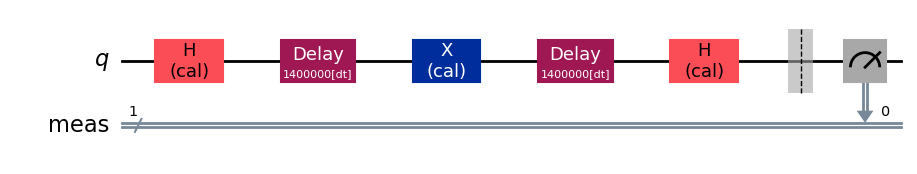

In [240]:
exp_t2_circuits[-1].draw('mpl')

In [252]:
device

<IBMBackend('ibm_osaka')>

In [253]:
num_shots_per_point = 2**10

job_t2 = device.run(exp_T2_circuits,
               shots = num_shots)

print(job_t2.job_id())


crexkkpwverg008vv0fg


In [22]:
job_t2 = service.job('crexkkpwverg008vv0fg')

In [23]:
t2_result = job_t2.result(timeout = 800)
t2counts = t2_result.get_counts()

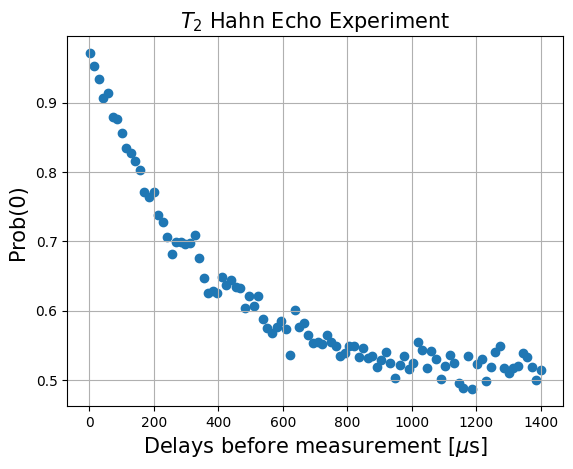

In [24]:
prob_0 = [i['0']/sum(i.values()) for i in t2counts]
plt.scatter(2*delay_times/us, prob_0) 
plt.title("$T_2$ Hahn Echo Experiment", fontsize=15)
plt.xlabel(r'Delays before measurement [$\mu$s]', fontsize=15)
plt.ylabel('Prob(0) ', fontsize=15)
plt.grid()
plt.show()

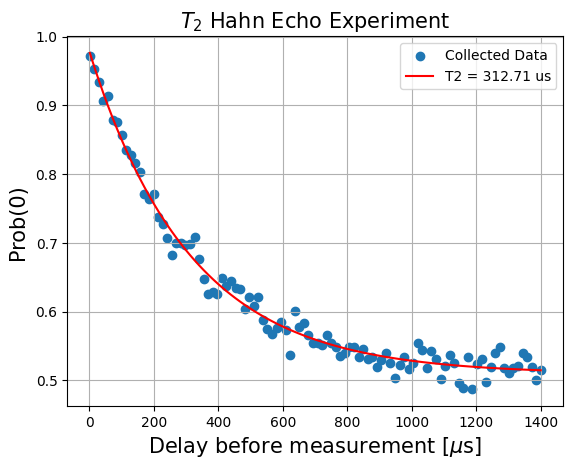

In [26]:
fit_params, y_fit = fit_function(2*delay_times/us, prob_0,
             lambda x, A, B, T2: (A * np.exp(-x / T2) + B),
             [-3, 0, 100])

T2 = fit_params[-1]


plt.scatter(2*delay_times/us, prob_0, label = 'Collected Data') 
plt.plot(2*delay_times/us, y_fit, c= 'red', label = f'T2 = {T2:.2f} us')
plt.title(r"$T_2$ Hahn Echo Experiment", fontsize=15)
plt.xlabel(r'Delay before measurement [$\mu$s]', fontsize=15)
plt.ylabel('Prob(0) ', fontsize=15)
plt.grid()
plt.legend()
plt.show()

In [258]:
error = ((T2-319.94)/319.94)*100
print(f'Error = {np.abs(error):.2f}%')

Error = 2.26%


Median T2 for qubit 0, as indicated on the IBM website is of $319.94 \text{us}$. Whereas in this experiment we found $312.71\text{us}$. 
An error of $\epsilon = 2.26\%$.

### Conclusion:
The experiments here aimed to show that, even using real Quantum Computers, we are able to determine the optimal amplitude for $\pi$ pulse, and consequently for the $\frac{\pi}{2}$ pulse also. In addition to this, we put these two pulses in practice running a $T_1$ and $T_2$ routines. In the case of $T_2$ we even used a Dynamical Decoupling technique called Hahn Echoes. In both cases we were able to accurately predict the values for both decoherence times of qubit 0 as shown above. 